# XBlock-M training, using Transformers

First we install a bunch of standard Python ML packages:

In [10]:
# %conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [1]:
#%conda install huggingface_hub transformers conda-forge::datasets evaluate accelerate pillow scikit-learn timm pandas "numpy<2" scikit-learn

Login to Huggingface Hub to ensure checkpoints upload

In [1]:
from huggingface_hub import notebook_login

notebook_login()

Import all the things

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import datasets
from accelerate import Accelerator, notebook_launcher
import evaluate
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, get_scheduler


In [3]:
metric = evaluate.load("accuracy")

We're loading [howdyaendra/xblock-social-screenshots](https://huggingface.co/datasets/howdyaendra/xblock-social-screenshots) from Hugging Face for our training data. This is a dataset I've been gradually building of high quality pre-labelled screenshots. You're welcome to use it for research and development purposes.

We take a 20% split of the screenshots to use as validation data.

In [4]:
dataset = datasets.load_dataset('howdyaendra/xblock-social-screenshots')
dataset = dataset['train'].train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/1618 [00:00<?, ?it/s]

This is a bog-standard "convert label IDs to strings and vice-versa" function

In [5]:
labels = dataset["train"].features["label"].names
num_classes = len(dataset["train"].features["label"].names)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

Yay! Now we can look at some samples from the dataset:

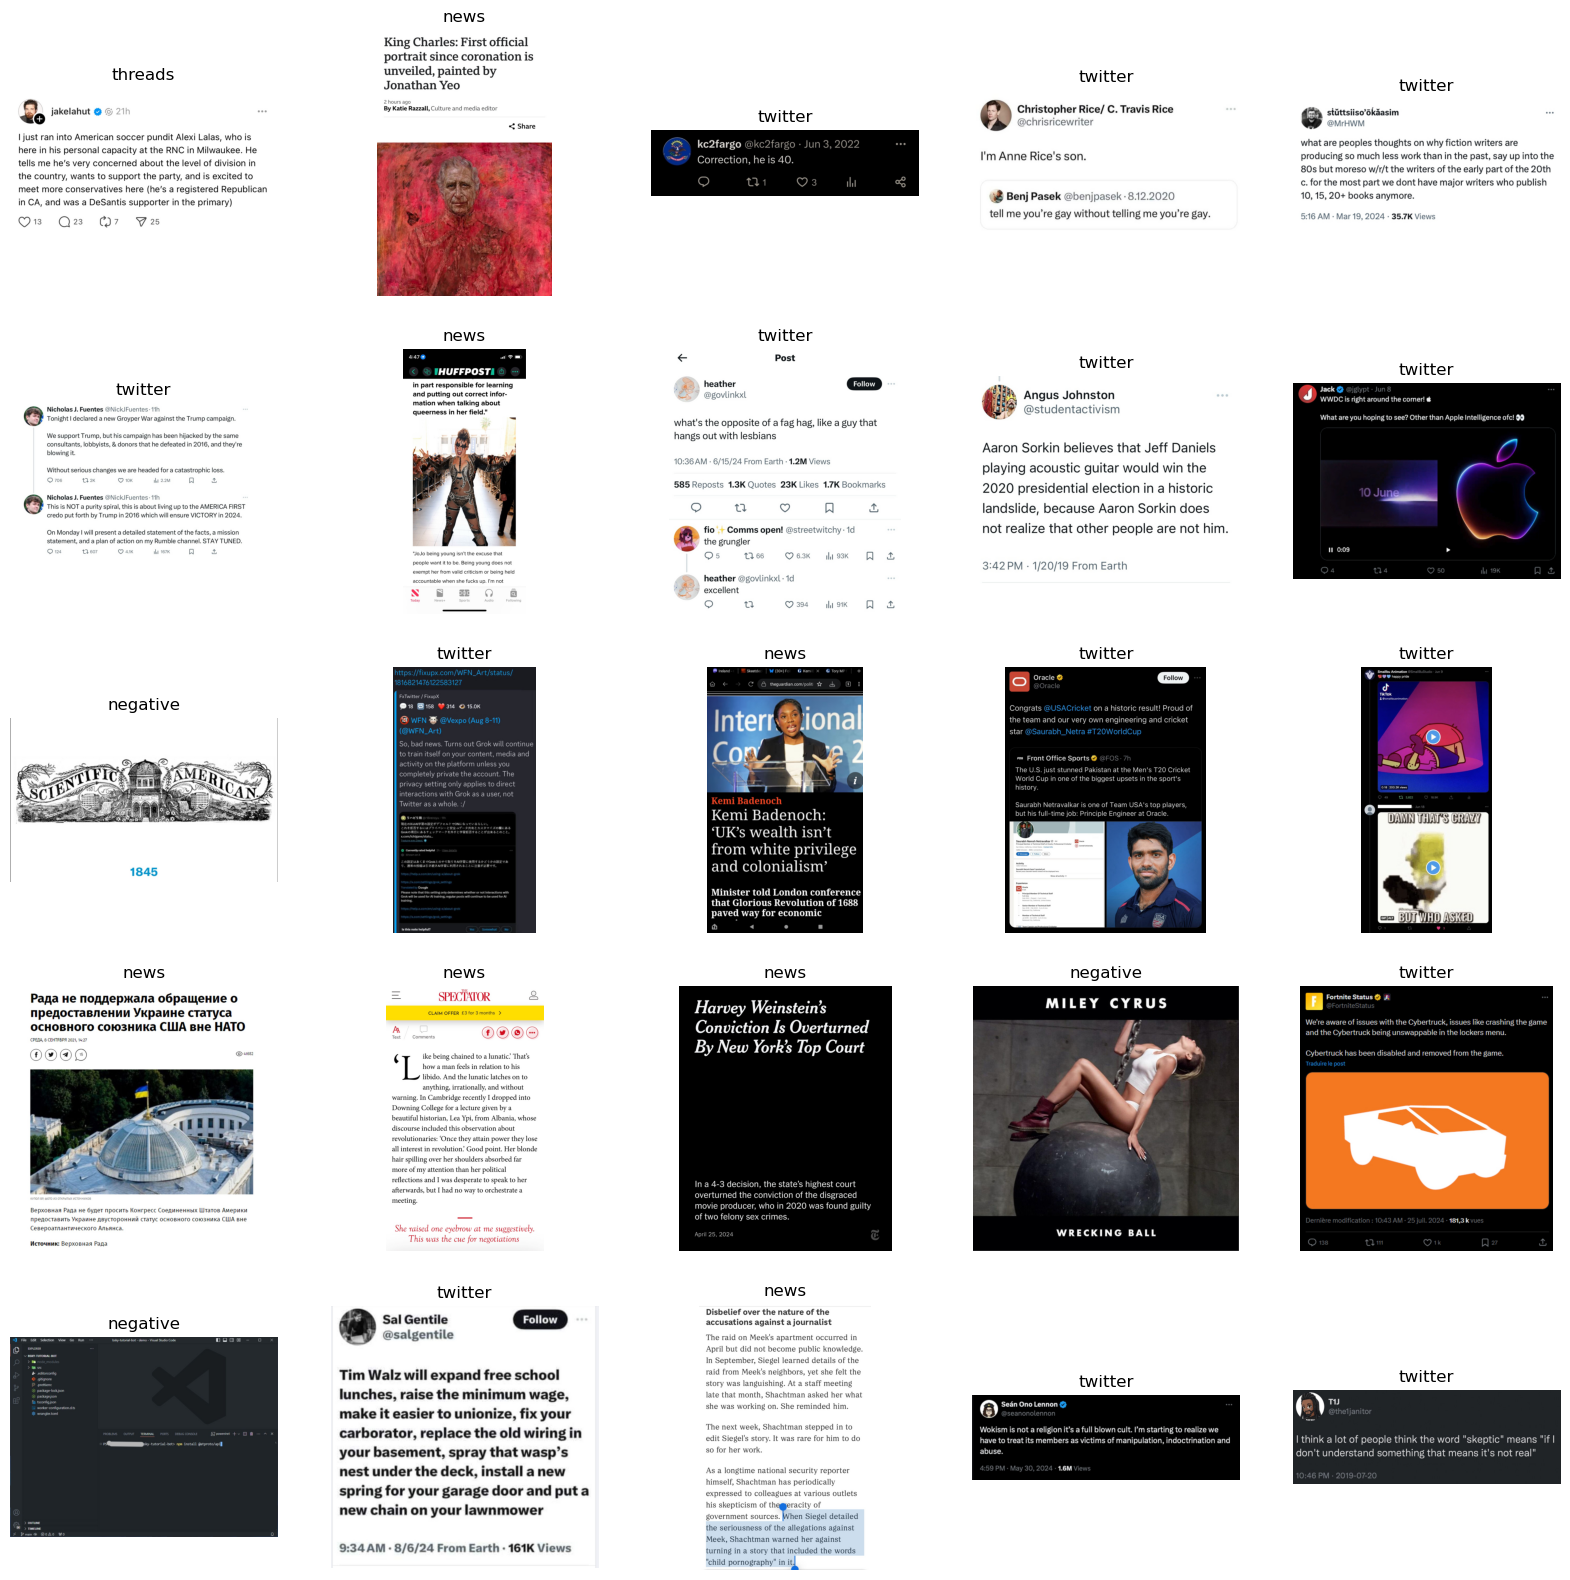

In [6]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        lb = samples[i]['label']
        # getting string labels and combining them with a comma
        labels = id2label[lb]
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(labels)
        plt.axis('off')

show_samples(dataset['train'],rows=5,cols=5)

We're using microsoft/swinv2-small-patch4-window16-256 as our base model. SwinV2 is really performant and good for both small and large images. You can use any model as a base, though. I'm very open to suggestions if you have a better one!

In [7]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/swinv2-small-patch4-window16-256"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

The following functions resize the test images and add a bunch of randomness to add some variance to the dataset. It also normalises them and converts them to tensors. 

In [8]:
img_size = (224,224)

train_tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

val_tfms = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

This is the magic sauce of XBlock-M. Instead of doing a softmax like the old XBlock model did, this does a one_hot conversation (i.e., using a sigmoid) so it doesn't flatten the probability space given a single screenshot can contain screenshots from multiple services. Previously, having multiple services would often result in neither having a high enough score to receive a label because of that flattening behaviour.

In [9]:
def preprocess_train(batch):
    # convert all images in batch to RGB to avoid grayscale or transparent images
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # apply torchvision.transforms per sample in the batch
    inputs = [train_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    # one-hot encoding the labels
    labels = torch.tensor([[x] for x in batch['label']])
    batch['labels'] = nn.functional.one_hot(labels,num_classes=num_classes)
    batch['labels'] = batch['labels'].sum(dim=1)

    return batch

def preprocess_val(batch):
    # convert all images in batch to RGB to avoid grayscale or transparent images
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # apply torchvision.transforms per sample in the batch
    inputs = [val_tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    # one-hot encoding the labels
    labels = torch.tensor([[x] for x in batch['label']])
    batch['labels'] = nn.functional.one_hot(labels,num_classes=num_classes)
    batch['labels'] = batch['labels'].sum(dim=1)

    return batch

Apply the transforms to the dataset...

In [10]:
train_ds = dataset['train']
val_ds = dataset['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

This collates the samples into batches by stacking the pixel values into a single tensor.

In [11]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }


We're ready to start training now! We need to pass `ignore_mismatched_sizes=True` because we're training a new head so it won't match the dimensions of the previous head

In [12]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True
)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-small-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tweak the below hyperparameters if you have any idea what you're doing (I sure don't, these are copied from some random Huggingface Notebook). Note particularly `num_train_epochs` which determines how many training epochs run.

In [13]:
training_args = TrainingArguments(
    output_dir=f"microsoft-swinv2-small-patch4-window16-256-finetuned-xblockm",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    push_to_hub=True,
)



In [14]:
# import numpy as np
# train_metric = evaluate.load('roc_auc','multilabel') # load metric

# # the compute_metrics function takes a Named Tuple as input:
# # predictions, which are the logits of the model as Numpy arrays,
# # and label_ids, which are the ground-truth labels as Numpy arrays.
# def compute_metrics(eval_pred):
#     """Computes accuracy on a batch of predictions"""
#     running_loss = 0.
    
#     return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)  # Convert logits to torch.Tensor if needed
    labels = torch.tensor(labels)  # Convert labels to torch.Tensor if needed

    roc_auc_metric = evaluate.load('roc_auc', 'multilabel')
    roc_auc_metric.add_batch(prediction_scores=logits, references=labels)
    roc_auc = roc_auc_metric.compute(average='micro')['roc_auc']
    
    return {"roc_auc": roc_auc}

In [15]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

In [16]:
accelerator = Accelerator() # create instance
# loss, optimizer, scheduler

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(),lr=2e-4,weight_decay=0.02)

scheduler = get_scheduler(
    "cosine",  # Using cosine scheduler
    optimizer=optimizer,
    num_warmup_steps = int(0.1 * len(train_ds)),
    num_training_steps=len(train_ds)
)

train_ds, val_ds, model, optimizer = accelerator.prepare(
    train_ds, val_ds, model, optimizer
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
    #preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

results = trainer.train()
trainer.save_model()


Epoch,Training Loss,Validation Loss,Roc Auc
0,0.435700,0.254428,0.778443
1,0.202700,0.201644,0.843077
2,0.174300,0.170112,0.891189
4,0.132100,0.144698,0.924619
5,0.115500,0.141809,0.931111
6,0.095900,0.138080,0.946035
7,0.078800,0.125181,0.953548


model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

In [17]:
trainer.log_metrics("train", results.metrics)
trainer.save_metrics("train", results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =      7.9012
  total_flos               = 421210681GF
  train_loss               =       0.192
  train_runtime            =  2:32:39.57
  train_samples_per_second =        1.13
  train_steps_per_second   =       0.017


In [18]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/howdyaendra/microsoft-swinv2-small-patch4-window16-256-finetuned-xblockm/commit/64025cec88b57fe95b9d821a3178fdd51ef91ce0', commit_message='End of training', commit_description='', oid='64025cec88b57fe95b9d821a3178fdd51ef91ce0', pr_url=None, pr_revision=None, pr_num=None)